# 15. Practice problems for the Final Exam

## Preamble

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.optimize import root, fsolve, curve_fit
from scipy.misc import derivative
import scipy.linalg as lg
# PDF = Probability Distribution Function (smooth Histogram)
from scipy.stats import gaussian_kde as PDF  
# find maximas (peaks) in a list
from scipy.signal import find_peaks

import sympy as sp
import fractions as fra
import itertools as itr

# install the tabulate module using: "conda install tabulate"
from tabulate import tabulate

from ipywidgets import interact

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [3]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

In [4]:
# ticklabels as multiples of pi
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))


In [5]:
# turn off certain annoying warnings 
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")

## Utility functions

In [7]:
# Bifurcation diagram: x vs r
def BF_diag(f,x1,x2,r1,r2,nx=80,nr=80,col='k',title='',x_lab='$r$',y_lab='$x^\star$'):
    fx = lambda x,r: derivative(f,x,dx=1e-6,args=(r,))
    x=np.linspace(x1,x2,nx)
    r=np.linspace(r1,r2,nr)
    R,X = np.meshgrid(r,x)
    Z = f(X,R)
    Zx= fx(X,R)
    Zu= np.ma.masked_where(Zx<0,Z)
    Zs= np.ma.masked_where(Zx>0,Z)

    fig, ax=plt.subplots(figsize=(6,4))
    ax.contour(R,X,Zs,levels=[0],colors=col,linewidths=3)
    ax.contour(R,X,Zu,levels=[0],colors=col,linewidths=3,linestyles='dashed')
    ax.grid()
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_title(title,color='b')
    plt.show()    

In [8]:
# Phase portrait: streamplot X,Y,Vx=dx/dt,Vy=dy/dt
def PP_2d(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)
    ax.streamplot(X,Y,U,V,density=dens,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax

# Phase portrait: streamlines through selected points
def PP_2d_sp(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    return ax    

# Phase portrait: streamlines through selected points + nullclines
def PP_2d_sp_nc(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Phase portrait: nullclines
def PP_nc(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,lw=1,c1='m',c2='b'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Display fixed points
def PP_FPs(FPs,tau,delta,ax,Print=True):
    ax = ax or plt.gca()
    for j in np.arange(len(FPs)):
        FP_ = np.array(FPs[j],dtype=float) 
        if tau[j]<0 and delta[j]>0:
            if Print: print('stable FP: ',FP_) 
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
        else:
            if Print: print('unstable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    return ax

In [9]:
def get_FP_data(f1,f2,tab=True):
    '''
    input: f1(x,y) and f2(x,y) for 2D dynamical system
    output: FPs and attributes: tau, delta, tau^2-4.delta, 
                                eigen-values/-vectors of Jacobian matrix
    '''
    FPs = sp.solve((f1(x,y),f2(x,y)),x,y) 
    FPsd= [{x:a[0],y:a[1]} for a in FPs]
    print('Fixed points: ',FPsd)

    A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])
    display(Latex(r'$A ={}$'.format(sp.latex(A(x,y)))))

    A_FPs = [A(x,y).subs(a) for a in FPsd]
    display(Latex(r'For each FP evaluate $A$, $\tau=Tr(A)$, $\Delta=det(A)$, $\tau^2-4\Delta$, $\lambda_{{1,2}}$, and $v_{{1,2}}$'))
    [display(a) for a in A_FPs];

    tau   = [a.trace() for a in A_FPs]
    display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
    delta = [a.det()   for a in A_FPs]
    display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
    disc  = [t**2 - 4*d for t,d in zip(tau,delta)]
    display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

    # calculate eigenvalues and eigenfunctions of the Jacobian matrices for each FP
    eig_sys = [a.eigenvects() for a in A_FPs]
    mu = [[a[0][0],a[1][0]] for a in eig_sys]
    display(Latex(r'$\lambda_{{1,2}} = {}$'.format(sp.latex(mu))))
    V  = [[list(a[0][2][0]),list(a[1][2][0])] for a in eig_sys]
    display(Latex(r'$V_{{1,2}} = {}$'.format(sp.latex(V))))

    # tabulate data for FPs
    if tab :
        table=[[FPsd[i],tau[i],delta[i],disc[i],mu[i],V[i]] for i in np.arange(len(FPs))]
        print(tabulate(table,headers=('Fixed point','tau','delta','disc','lambda','eigenvectors'),
                   tablefmt='fancy_grid'))
    return FPs, tau, delta, disc, mu, V

In [10]:
# functions to calculate trajectory {x(t),y(t)} numerically for given {x0,y0} 
# input: functions f1,f2; duration T and timestep dt of trajectory; initial condition xy0=[x0,y0]
# output: [t,sol] = [t,[x(t),y(t)]]

def txy_traj(f1,f2,T,dt,xy0):
    t = np.arange(0,T+dt,dt)
    def RHS(xy,t):
        x,y=xy
        return[f1(x,y),f2(x,y)]
    sol = odeint(RHS,xy0,t)
    return [t,sol]

In [11]:
# functions to solve LE  
# input: parameters sigma,a,b; duration T and timestep dt; initial condition xyz0=[x0,y0,z0]
# output: [t,sol] = [t,[x(t),y(t),z(t)]]

def txyz_LE(sigma,r,b,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[sigma*(y-x),r*x-y-x*z,x*y-b*z]
    sol = odeint(RHS,xyz0,t)
    return [t,sol]

In [12]:
# functions to solve the Rossler system (RS) 
# input: parameters sigma,a,b; duration T and timestep dt; initial condition xyz0=[x0,y0,z0]
# output: [t,sol] = [t,[x(t),y(t),z(t)]]

def txyz_RS(a,b,c,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[-y-z,x+a*y,b+z*(x-c)]
    sol = odeint(RHS,xyz0,t)
    return [t,sol]

In [13]:
# NestList(f,x0,n0) and Nest(f,x,n)
def NestList(f,x0,n0):
    '''
    generate nested list by applying f n=0,...,n0 times on x0
    input:  f(x,_), x0, n0=integer
    output: [x0,f(x0),f(f(x0)),...,f(...(f(x0)))]
    '''
    return [a for a in itr.accumulate(itr.repeat(x0,n0),f)]

def Nest(f,x,n):
    '''Applies function f n-times to x'''
    if n==0:
        return x
    return Nest(f,f(x),n-1)

In [14]:
# define Logistic Map (LM) and LM series
f_LM = lambda x,r: r*x*(1-x)
def logistic_series(x0,r,n):
    f = lambda x,_: f_LM(x,r)
    return NestList(f,x0,n)

In [15]:
# plot cobweb x_(n+1)=f(x_n)
def cobweb_f(f,x0,n0,ax,ls='-',col='r',lw=1):
    ax = ax or plt.gca
    f_ = lambda x,_: f(x)
    dat = NestList(f_,x0,n0)
    x = list(itr.chain(*zip(dat,dat)))
    ax.plot(x[:-1],x[1:],c=col,ls=ls,lw=lw)
    return ax

# plot cobweb {x_0,...,x_n}
def cobweb_x(xdat,ax,ls='-',col='r',lw=1,nS=1):
    ax = ax or plt.gca
    x = list(itr.chain(*zip(xdat,xdat)))
    ax.plot(x[nS:-1],x[nS+1:],c=col,ls=ls,lw=lw)
    return ax

In [16]:
# define HM and T_i, i=1,2,3
def fT1(xy,a):
    x,y = xy
    return [x,1+y-a*x**2]
def fT2(xy,b):
    x,y=xy
    return [b*x,y]
def fT3(xy):
    x,y=xy
    return [y,x]
def HM(xy,a,b):
    x,y=xy
    return [y+1-a*x**2,b*x]

# define HM series
def HM_series(xy0,a,b,n):
    f = lambda xy,_: HM(xy,a,b)
    return NestList(f,xy0,n)

## P1

Consider the following "rabbits vs. sheep" problems, 
$\dot{x}=x(3-2x-2y)$, $\dot{y}=y(2-x-y)$,  where $x,y\ge 0$.

(a) Find the fixed points and their stability. 

(b) Plot the phase portrait, including the nullclines. 

(c) Indicate the basins of attraction of any stable fixed points.

#### (a) Find the fixed points and their stability. 

In [17]:
x,y= sp.symbols('x,y',nonnegative=True)
f1 = lambda x,y: x*(3-2*x-2*y)
f2 = lambda x,y: y*(2-x-y)
FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2);

Fixed points:  [{x: 0, y: 0}, {x: 0, y: 2}, {x: 3/2, y: 0}]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Matrix([
[3, 0],
[0, 2]])

Matrix([
[-1,  0],
[-2, -2]])

Matrix([
[-3,  -3],
[ 0, 1/2]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

╒════════════════╤═══════╤═════════╤════════╤═══════════╤═════════════════════╕
│ Fixed point    │   tau │   delta │   disc │ lambda    │ eigenvectors        │
╞════════════════╪═══════╪═════════╪════════╪═══════════╪═════════════════════╡
│ {x: 0, y: 0}   │   5   │     6   │   1    │ [2, 3]    │ [[0, 1], [1, 0]]    │
├────────────────┼───────┼─────────┼────────┼───────────┼─────────────────────┤
│ {x: 0, y: 2}   │  -3   │     2   │   1    │ [-2, -1]  │ [[0, 1], [-1/2, 1]] │
├────────────────┼───────┼─────────┼────────┼───────────┼─────────────────────┤
│ {x: 3/2, y: 0} │  -2.5 │    -1.5 │  12.25 │ [-3, 1/2] │ [[1, 0], [-6/7, 1]] │
╘════════════════╧═══════╧═════════╧════════╧═══════════╧═════════════════════╛


#### (b) Plot the phase portrait, including the nullclines. 

unstable FP:  [0. 0.]
stable FP:  [0. 2.]
unstable FP:  [1.5 0. ]


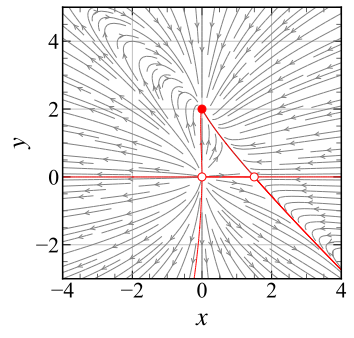

In [18]:
# phase portrait

x1 = -4; x2 = 4
y1 = -3; y2 = 5

d0 = 2

n1=20; n2=12; n3=10
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)

fig_P1, ax = plt.subplots(figsize=(5,5))

# automated streamlines
PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=1.5,col='gray')

# selected streamlines
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n1),pp1(n1)*2]),ax,col='gray',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n3)*x1,ppx(-1.8,1.8,n3)]),ax,col='gray',dens=d0)

# plot nulclines
# PP_nc(x1,x2,y1,y2,f1,f2,ax)

# display fixed points
PP_FPs(FPs,tau,delta,ax)

# FPs and streamlines along eigenvector directions
d0=4
s =10
for j in [0,2]: #np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float)
    V_  = np.array(V[j],dtype=float)
    PP_2d_sp(x1,x2,y1,y2,f1,f2,(FP_+V_/s).T,ax,col='r',dens=d0,ar_s='-')
    PP_2d_sp(x1,x2,y1,y2,f1,f2,(FP_-V_/s).T,ax,col='r',dens=d0,ar_s='-')


# ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
# ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

#### (c) Indicate the basins of attraction of any stable fixed points.

## P2

Consider the dynamical system    $\dot{x}=\sin⁡(y)$, $\dot{y}=x^3-y$.

(a) Find the fixed points and classify them.

(b) Plot the nullclines.

(c) Plot the phase portrait and discuss it.

#### (a) Find the fixed points and classify them.

In [ ]:
x,y= sp.symbols('x,y',nonnegative=True)
f1 = lambda x,y: sp.sin(y)
f2 = lambda x,y: x**3-y
FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2,tab=False);

#### (b) Plot the nullclines.
#### (c) Plot the phase portrait and discuss it.

In [ ]:
# phase portrait
f1 = lambda x,y: np.sin(y)
x1 = -np.pi; x2 = np.pi
y1 = -5; y2 = 5

d0 = 2

n1=20; n2=12; n3=10
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)

fig_P1, ax = plt.subplots(figsize=(5,5))

# automated streamlines
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=1.5,col='gray')

# selected streamlines
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n1),pp1(n1)*0]),ax,col='gray',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-0.8,1.2,n3),-pp1(n3)*3]),ax,col='gray',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-1.2,0.8,n3),pp1(n3)*3]),ax,col='gray',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n3)*x1,ppx(-1.8,1.8,n3)]),ax,col='gray',dens=d0)

# plot nulclines
PP_nc(x1,x2,y1,y2,f1,f2,ax)

# display fixed points
PP_FPs(FPs,tau,delta,ax)

nFPs = np.array(FPs,dtype=float)
PP_FPs(-nFPs,tau,delta,ax,Print=False)


# ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
# ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## P3

Consider the dynamical system  $\dot{x}=-x-y+x(x^2+2y^2)$, $\dot{y}=x-y+y(x^2+2y^2)$.

(a) Find the fixed points and classify them.

(b) Find the limit cycles (if any) and classify them.

(c) Plot the phase portrait, including the nullclines.

In [ ]:
x,y= sp.symbols('x,y',nonnegative=True)
f1 = lambda x,y: -x-y+x*(x**2+2*y**2)
f2 = lambda x,y: x-y+y*(x**2+2*y**2)
FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2,tab=False);

In [ ]:
# convert (x,y) to (r,q)
r,q= sp.symbols('r,q',nonnegative=True)
f1rq = f1(x,y).subs({x: r*sp.cos(q),y: r*sp.sin(q)})
f2rq = f2(x,y).subs({x: r*sp.cos(q),y: r*sp.sin(q)})
r_dot= (f1rq*sp.cos(q)+f2rq*sp.sin(q)).simplify(trig=True).together()
q_dot= ((f2rq*sp.cos(q)-f1rq*sp.sin(q))/r).simplify(trig=True).together()
display(Latex('$\dot{{r}}={}$'.format(sp.latex(r_dot))))
display(Latex('$\dot{{q}}={}$'.format(sp.latex(q_dot))))
# solve dr/dt=0
r0,r1 = sp.solve(r_dot,r)
display(Latex('Limit cycle: $r(q)={}$'.format(sp.latex(r1))))
# convert (r,q) to (xLC,yLC) on the limit cycle
xLC = sp.lambdify(q,r1*sp.cos(q),'numpy')
yLC = sp.lambdify(q,r1*sp.sin(q),'numpy')

In [ ]:
# phase portrait
x1 = -2; x2 = 2
y1 = -2; y2 = 2

d0 = 2

n1=20; n2=12; n3=10
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)

fig_P1, ax = plt.subplots(figsize=(5,5))

# automated streamlines
PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=1.5,col='gray')

# selected streamlines
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n1),pp1(n1)*0]),ax,col='gray',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-0.8,1.2,n3),-pp1(n3)*3]),ax,col='gray',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-1.2,0.8,n3),pp1(n3)*3]),ax,col='gray',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n3)*x1,ppx(-1.8,1.8,n3)]),ax,col='gray',dens=d0)

# plot nulclines
PP_nc(x1,x2,y1,y2,f1,f2,ax)

# display fixed points
PP_FPs(FPs,tau,delta,ax)

# Plot unstable Limit Cycle
qq = np.linspace(0,2*np.pi,100)
ax.plot(xLC(qq),yLC(qq),'r-',lw=3,alpha=0.5)

# ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
# ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## P4

A chemical oscillator is described by the 2D dynamical system
$\dot{x}=a-x+x^2 y$, $\dot{y}=b-x^2 y$, where $a,b>0$ are parameters and $x,y>0$ are dimensionless concentrations.

(a) Show that the system has a unique fixed point and classify it.

(b) Show that the system undergoes a Hopf bifurcation when $b-a=(a+b)^3$.

(c) Is the Hopf bifurcation subcritical or supercritical? Use a computer to decide (i.e., construct and compare two relevant phase portraits before and after the Hopf bifurcation, e.g., by fixing one parameter (e.g., $b=0.5$) and varying the other).

(d) Plot the stability diagram in a,b space. Indicate clearly the regions where the system has a stable fixed point or a stable limit cycle.

_Hint: Show that the bifurcation curve can be written in parametric form as $a=x^* (1-x^{*2})/2$, $b=x^* (1+x^{*2})/2$, where $x^*>0$ is the x-coordinate of the fixed point._


#### (a) Show that the system has a unique fixed point and classify it.

In [ ]:
x,y,a,b= sp.symbols('x,y,a,b',nonnegative=True)
f1 = lambda x,y: a-x+x*x*y
f2 = lambda x,y: b-x*x*y
FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2,tab=False);

In [ ]:
# the determinant is always positive
delta0 = delta[0].factor()
delta0

In [ ]:
# the trace is [a-b - (a+b)^3]/(a+b)
tau0=tau[0].together()
tau0

In [ ]:
# discriminant
disc0=(tau0**2-4*delta0).together()
disc0

#### (e) Plot the stability diagram in a,b space. Indicate clearly the regions where the system has a stable fixed point or a stable limit cycle.

- Stable FP: $\tau<0$ and FP is a spiral (node) when $\tau^2-4\Delta<0$ $(>0)$

- Stable LC (surrounds unstable FP): $\tau>0$ 

In [ ]:
FPs_ =  sp.lambdify([a,b],FPs,'numpy')
tau_ =  sp.lambdify([a,b],tau0,'numpy')
tau1 =  sp.lambdify([a,b],sp.numer(tau0),'numpy')
delta_= sp.lambdify([a,b],delta,'numpy')
disc_ = sp.lambdify([a,b],disc0,'numpy')
disc1 = sp.lambdify([a,b],sp.numer(disc0),'numpy')

# plot the stability diagram (a,b)
n_=100
a_=np.linspace(0,0.3,n_)
b_=np.linspace(0,1.2,n_)

A,B = np.meshgrid(a_,b_)
ZTau= tau1(A,B)
ZDisc= disc1(A,B)

fig, ax=plt.subplots(figsize=(6,4))

# delimit region with tau<0 (>0) = (un)stable FP
ax.contourf(A,B, ZTau,levels=[0,100],colors=['gold','g','c','m'],alpha=0.5)
ax.contour(A,B,  ZTau,levels=[0],colors=['k','g','c','m'],linewidths=3,alpha=1)

# parametric plot of the HB curve
u = np.linspace(0,1,100)
ax.plot(u*(1-u*u)/2,u*(1+u*u)/2,'r-',lw=1)

ax.grid()

ax.set_ylim(0,1.1)
# ax.set_xticks(np.arange(0.2,1.3,0.2))
ax.set_yticks(np.arange(0.2,1.2,0.2))

ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

# annotations
ax.text(0.05,0.45,'stable LC',fontsize=22)
ax.text(0.18,0.8,'stable FP',fontsize=22,bbox=dict(fc='w',ec='w',alpha=0.9))

plt.show()

In [ ]:
# plot the stability diagram (a,b)
n_=100
a_=np.linspace(0,0.3,n_)
b_=np.linspace(0,1.2,n_)

A,B = np.meshgrid(a_,b_)
ZTau= tau1(A,B)
ZDisc= disc1(A,B)

fig, ax=plt.subplots(figsize=(6,4))
# delimit region with tau<0 (>0) = (un)stable FP
ax.contourf(A,B, ZTau,levels=[0,200],colors=['gold','g','c','m'],alpha=0.5)
ax.contour(A,B, ZTau,levels=[0],colors=['k','g','c','m'],linewidths=3,alpha=1)

# delimit region with node (spiral) FP, i.e., disc >0 (<0)
ax.contourf(A,B,np.ma.masked_where(ZTau>0,ZDisc),levels=[-100,0,100],colors=['c','m','lightgray'],alpha=0.2)
ax.contour(A,B,np.ma.masked_where(ZTau>0,ZDisc),levels=[0],colors=['r','g','c','m'],linewidths=1,alpha=1)
# ax.contour(A,B,ZDisc,levels=[0],colors=['k','g','c','m'],linewidths=1,alpha=0.5)

ax.grid()
ax.set_ylim(0,1.1)
ax.set_yticks(np.arange(0.2,1.2,0.2))

ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

# annotations
ax.text(0.05,0.45,'stable LC',fontsize=22)
ax.text(0.18,0.8,'stable FP',fontsize=22)

ax.text(0.2,0.65,'spiral',fontsize=18)

ax.annotate('node',fontsize=18,
            xy=(0.19,0.02),xycoords='data',
            xytext=(30,50),textcoords='offset points',
            arrowprops=dict(arrowstyle='->',lw=1.5))

plt.show()

In [ ]:
# plot the stability diagram (a,b)
n_=100
a_=np.linspace(0,3,n_)
b_=np.linspace(0,1.5,n_)

A,B = np.meshgrid(a_,b_)
ZTau= tau1(A,B)
ZDisc= disc1(A,B)

fig, ax=plt.subplots(figsize=(6,4))
# delimit region with tau<0 (>0) = (un)stable FP
ax.contourf(A,B, ZTau,levels=[0,200],colors=['gold','g','c','m'],alpha=0.5)
ax.contour(A,B, ZTau,levels=[0],colors=['k','g','c','m'],linewidths=3,alpha=1)

# delimit region with node (spiral) FP, i.e., disc >0 (<0)
ax.contourf(A,B,np.ma.masked_where(ZTau>0,ZDisc),levels=[-100,0,1e8],colors=['c','m','lightgray'],alpha=0.2)
ax.contour(A,B,np.ma.masked_where(ZTau>0,ZDisc),levels=[0],colors=['r','g','c','m'],linewidths=1,alpha=1)
# ax.contour(A,B,ZDisc,levels=[0],colors=['k','g','c','m'],linewidths=1,alpha=0.5)

ax.grid()
# ax.set_ylim(0,2)
# ax.set_yticks(np.arange(0.2,1.2,0.2))

ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

# annotations
ax.text(0.04,0.25,'stable LC',rotation=90,fontsize=15)
ax.text(1,0.8,'stable FP',fontsize=18,bbox=dict(fc='w',ec='k',alpha=0.7))

ax.text(0.65,0.4,'spiral',fontsize=18)
ax.text(2.1,1.1,'node',fontsize=18)


plt.show()

#### (b) Show that the system undergoes a Hopf bifurcation when $b-a=(a+b)^3$.

#### (c) Is the Hopf bifurcation subcritical or supercritical? Use a computer to decide (i.e., construct and compare two relevant phase portraits before and after the Hopf bifurcation, e.g., by fixing one parameter (e.g., $b=0.5$) and varying the other).

In [ ]:
# LC + unstable FP
a1=0.15;b1=0.5

f1_ = sp.lambdify([x,y],f1(x,y).subs({a:a1,b:b1}))
f2_ = sp.lambdify([x,y],f2(x,y).subs({a:a1,b:b1}))

FPs_ = sp.lambdify([a,b],FPs,'numpy')
tau_ = sp.lambdify([a,b],tau,'numpy')
delta_=sp.lambdify([a,b],delta,'numpy')

T = 100; dt=0.1; xy0=[1,1]
t0= 80; t0_=int(t0/dt)
t, sol = txy_traj(f1_,f2_,T,dt,xy0)

In [ ]:
# phase portrait
x1 = 0; x2 = 2.5
y1 = 0; y2 = 2.5

d0 = 6

n1=20; n2=12; n3=8
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)


fig_P4, ax = plt.subplots(figsize=(5,5))

# automated streamlines
# PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1.2,col='gray')

# selected streamlines
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(1,x2,n2),pp1(n2)*2]),ax,col='gray',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(0,1,n3),pp1(n3)*0.7]),ax,col='gray',dens=d0)

# plot nulclines
PP_nc(x1,x2,y1,y2,f1_,f2_,ax)

# display fixed points
PP_FPs(FPs_(a1,b1),tau_(a1,b1),delta_(a1,b1),ax)

# Plot Limit Cycle
ax.plot(sol[t0_:,0],sol[t0_:,1],'r-',lw=3,alpha=0.8)

# ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_yticks(np.arange(0.5,3,0.5))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

In [ ]:
# stable FP no LC
a2=0.25;b2=0.5

f1_ = sp.lambdify([x,y],f1(x,y).subs({a:a2,b:b2}))
f2_ = sp.lambdify([x,y],f2(x,y).subs({a:a2,b:b2}))

FPs_ = sp.lambdify([a,b],FPs,'numpy')
tau_ = sp.lambdify([a,b],tau,'numpy')
delta_=sp.lambdify([a,b],delta,'numpy')

T = 100; dt=0.1; xy0=[1,1]
t0= 80; t0_=int(t0/dt)
t, sol2 = txy_traj(f1_,f2_,T,dt,xy0)

In [ ]:
# phase portrait
x1 = 0; x2 = 2.5
y1 = 0; y2 = 2.5

d0 = 6

n1=16; n2=10; n3=6
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)


fig_P4, ax = plt.subplots(figsize=(5,5))

# automated streamlines
# PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1.2,col='gray')

# selected streamlines
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(1,x2,n2),pp1(n2)*1.8]),ax,col='gray',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(0,1,n3),pp1(n3)*0.7]),ax,col='gray',dens=d0)

# plot nulclines
PP_nc(x1,x2,y1,y2,f1_,f2_,ax)

# display fixed points
PP_FPs(FPs_(a2,b2),tau_(a2,b2),delta_(a2,b2),ax)

# Plot Limit Cycle
ax.plot(sol2[t0_:,0],sol2[t0_:,1],'r-',lw=3,alpha=0.8)

# ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_yticks(np.arange(0.5,3,0.5))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## P5

Consider the map $x_{n+1}=r \exp⁡(x_n)$, for $r>0$.

(a) Analyze the map by drawing a cobweb.

(b) Show that a tangent bifurcation occurs at $r_0=1/e$.

(c) Sketch the time series $x_n$ vs $n$ for $r$ just above and just below $r_0=1/e$.

## P6

Calculate the _Liapunov exponent_ for the linear map $x_{n+1}=r x_n$.